In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy

from tqdm import tqdm

import torch
from torch import nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

In [30]:
class Dataset(torch.utils.data.Dataset):
    'Characterizes a dataset for PyTorch'
    def __init__(self, X, y):
        'Initialization'
        self.y = y
        self.X = X

    def __len__(self):
        'Denotes the total number of samples'
        return len(self.X)

    def __getitem__(self, index):
        'Generates one sample of data'
        
        return self.X, self.y

In [2]:
sst_normed = np.load('../CESM_data/CESM_SST_normalized.npy').astype(np.float32)
sss_normed = np.load('../CESM_data/CESM_SSS_normalized.npy').astype(np.float32)

In [23]:
lead = 24
tstep = 1032
channels = 2

In [5]:
y = np.mean(sst_normed[:,lead:,:,:],axis=(2,3)).reshape((tstep-lead)*42,1)  
X = np.transpose(
    np.array([sst_normed,sss_normed])[:,:,0:tstep-lead,:,:].reshape(channels,(tstep-lead)*42,33,89),
    (1,0,2,3))

In [34]:
percent_train = 0.2

X_train = torch.from_numpy( X[0:int(np.floor(percent_train*(tstep-lead)*42)),:,:,:] )
y_train = torch.from_numpy( y[0:int(np.floor(percent_train*(tstep-lead)*42)),:] )

X_val = torch.from_numpy( X[int(np.floor(percent_train*(tstep-lead)*42)):,:,:,:] )
y_val = torch.from_numpy( y[int(np.floor(percent_train*(tstep-lead)*42)):,:] )

In [35]:
params = {'batch_size': 32,
          'shuffle': True}

use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
torch.backends.cudnn.benchmark = True
max_epochs = 1

In [36]:
training_set = Dataset(X_train, y_train)
training_generator = torch.utils.data.DataLoader(training_set, **params)

In [37]:
for epoch in range(max_epochs):
    # Training
    for local_batch, local_labels in training_generator:
        # Transfer to GPU
        print(local_batch)

RuntimeError: [enforce fail at CPUAllocator.cpp:65] . DefaultCPUAllocator: can't allocate memory: you tried to allocate 6366100224 bytes. Error code 12 (Cannot allocate memory)

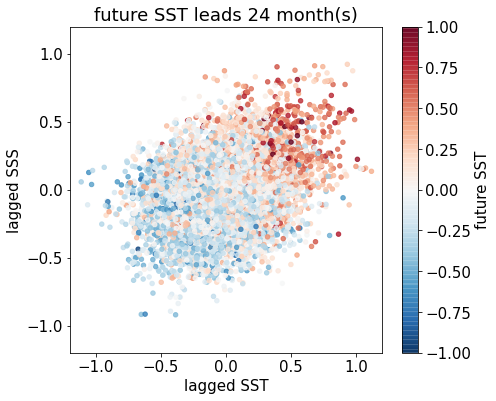

In [7]:
plt.figure(figsize=(7,6))
plt.rcParams.update({'font.size': 15})

sc = plt.scatter(np.mean(X_train[:,0,:,:].numpy(),axis=(1,2)),
                 np.mean(X_train[:,1,:,:].numpy(),axis=(1,2)),
                 c=y_train.numpy(),vmin=-1,vmax=1,cmap='RdBu_r',s=20,alpha=0.8)

plt.colorbar(sc,label='future SST')
plt.ylim([-1.2,1.2])
plt.xlim([-1.2,1.2])
plt.xlabel('lagged SST')
plt.ylabel('lagged SSS')
plt.title('future SST leads '+str(lead)+' month(s)')
plt.show()

In [8]:
model = nn.Sequential(nn.Conv2d(in_channels=channels, out_channels=32, kernel_size=5),
          nn.ReLU(),
          nn.MaxPool2d(kernel_size=5),
                      
          nn.Flatten(),
          nn.Linear(in_features=5*17*32,out_features=128),
          nn.ReLU(),
          nn.Linear(in_features=128,out_features=64),
          nn.ReLU(),
          
          nn.Dropout(p=0.5),
          nn.Linear(in_features=64,out_features=1))

opt = torch.optim.Adadelta(model.parameters())
loss_fn = nn.MSELoss()

In [9]:
epoch = 20

epo_losses = []

model.train()

for i in tqdm(range(epoch)):
    # Forward pass
    y_pred = model(X_train)
    
    # Compute Loss
    loss = loss_fn(y_pred.squeeze(), y_train.squeeze())
    epo_losses.append(loss.item())
    
    # update
    opt.zero_grad()
    loss.backward()
    opt.step()

  0%|          | 0/20 [00:00<?, ?it/s]/home/pdwang/miniconda3/envs/ml_env/lib/python3.8/site-packages/torch/autograd/__init__.py:130: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /opt/conda/conda-bld/pytorch_1603729096996/work/c10/cuda/CUDAFunctions.cpp:100.)
  Variable._execution_engine.run_backward(
  0%|          | 0/20 [00:02<?, ?it/s]


RuntimeError: [enforce fail at CPUAllocator.cpp:65] . DefaultCPUAllocator: can't allocate memory: you tried to allocate 4007104000 bytes. Error code 12 (Cannot allocate memory)